In [8]:
import osmnx
import networkx
import pickle
import main
import dask.dataframe as dd

network_types = ["bike", "walk", "drive"]

crime_weights = {
    "Other Assaults": 0.5,
    "Aggravated Assault No Firearm": 0.7,
    "Aggravated Assault Firearm": 1.0,
    "Thefts": 0.7,
    "Weapon Violations": 0.4,
    "All Other Offenses": 0.2,
    "Vandalism/Criminal Mischief": 0.2,
    "Motor Vehicle Theft": 0.7,
    "Robbery No Firearm": 0.6,
    "Theft from Vehicle": 0.4,
    "Narcotic / Drug Law Violations": 0.3,
    "Fraud": 0.1,
    "Arson": 0.3,
    "Embezzlement": 0.1,
    "Burglary Non-Residential": 0.5,
    "Burglary Residential": 0.6,
    "Other Sex Offenses (Not Commercialized)": 0.9,
    "Receiving Stolen Property": 0.3,
    "Robbery Firearm": 1.0,
    "Vagrancy/Loitering": 0.1,
    "Rape": 1.0,
    "Offenses Against Family and Children": 0.8,
    "Disorderly Conduct": 0.2,
    "DRIVING UNDER THE INFLUENCE": 0.6,
    "Prostitution and Commercialized Vice": 0.3,
    "Forgery and Counterfeiting": 0.2,
    "Public Drunkenness": 0.2,
    "Homicide - Criminal": 1.0,
    "Liquor Law Violations": 0.1,
    "Gambling Violations": 0.1,
    "Homicide - Justifiable": 0.1,
    "Homicide - Gross Negligence": 0.6,
}


def normalize_score(score, min_score, max_score):
    # Avoid division by zero if all scores are the same

    return (score - min_score) / (max_score - min_score)


In [ ]:
## LOADS DATA INTO DATA FOLDER TO MAKE IT EASIER TO LOAD CITY GRAPHS 

for type in network_types:
    graph = osmnx.graph_from_place("Philadelphia, Pennsylvania, USA", network_type=type)

    with open(f"datta/graphs/city_graph_{type}.pkl", "wb") as file:
        pickle.dump(graph, file)

In [3]:
graph = []
for index, type in enumerate(network_types):
    with open(f"data/graphs/city_graph_{type}.pkl", "rb") as file:
        graph.append(pickle.load(file))

    # osmnx.plot_graph(graph[index], node_size=0, edge_linewidth=0.1, save=True, filepath=f"data/graphs/city_graph_{type}.png")

test_graph = graph[0]

In [4]:
dtype_spec = {
    "point_x": "float64",
    "point_y": "float64",
    "hour": "float64",  # Ensure 'hour' is treated as a float
    "psa": "object",  # Ensure 'psa' is treated as a string (object)
}


df = dd.read_csv("data/crime_data.csv", dtype=dtype_spec)
df["dispatch_date"] = dd.to_datetime(df["dispatch_date"], format="%Y-%m-%d")
df["year"] = df["dispatch_date"].dt.year
df["month"] = df["dispatch_date"].dt.month
df["day"] = df["dispatch_date"].dt.day

filtered_df = df[
    (df["year"] >= 2021)
    # & (df["month"] == 9)
    # & (df["day"] == 1)
    & (df["point_x"].notnull())
    & (df["point_y"].notnull())
    & (df["text_general_code"].notnull())
]

point_x_list = filtered_df["point_x"].compute().tolist()
point_y_list = filtered_df["point_y"].compute().tolist()

crime_results = filtered_df.compute()
nearest_edges = osmnx.distance.nearest_edges(test_graph, X=point_x_list, Y=point_y_list)

In [5]:
for i in test_graph.edges:
    test_graph.edges[i]["crime_weight"] = 0

for (index, row), (u, v, k) in zip(crime_results.iterrows(), nearest_edges):
    test_graph[u][v][k]["crime_weight"] += crime_weights[row["text_general_code"]]

# for u, v, k in nearest_edges:
#     print(test_graph[u][v][k])

In [15]:
all_crime_weights = [test_graph.edges[i]["crime_weight"] for i in test_graph.edges]
min_cw, max_cw = min(all_crime_weights), max(all_crime_weights)

all_lengths = [test_graph.edges[i]["length"] for i in test_graph.edges]
min_l, max_l = min(all_lengths), max(all_lengths)


for i in test_graph.edges:
    test_graph.edges[i]["crime_weight"] = normalize_score(
        test_graph.edges[i]["crime_weight"], min_score=min_cw, max_score=max_cw
    )
    

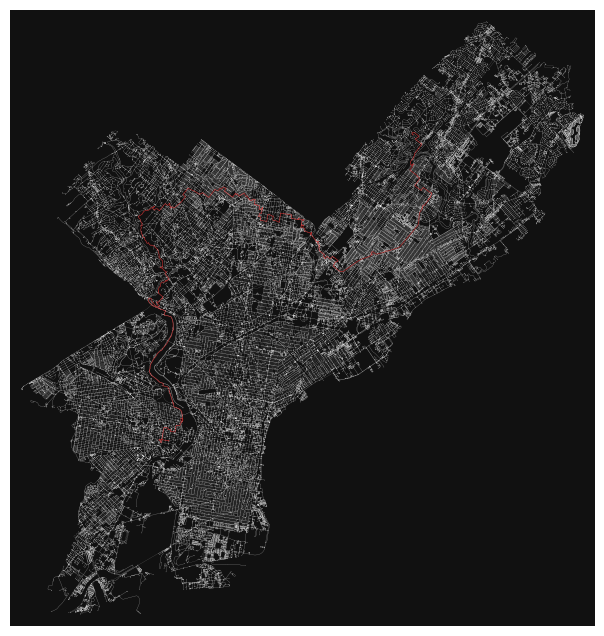

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [16]:
# type = "drive"
# with open(f"data/graphs/city_graph_{type}.pkl", "rb") as file:
#     graph = pickle.load(file)

orig_point = (-75.0554076, 40.0866726)
dest_point = (-75.1957886, 39.9522188)

orig_node = osmnx.nearest_nodes(test_graph, orig_point[0], orig_point[1])
dest_node = osmnx.nearest_nodes(test_graph, dest_point[0], dest_point[1])

shortest_path = osmnx.shortest_path(test_graph, orig_node, dest_node, weight="crime_weight")


osmnx.plot_graph_route(
    test_graph,
    shortest_path,
    route_color="red",
    route_linewidth=0.5,
    orig_dest_size=0.5,
    node_size=0.1,
    edge_linewidth=0.1,
    save=True,
    filepath=f"data/test_graph_{type}.png",
)

In [10]:
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import pandas as pd

# Read the CSV file
df = pd.read_csv("data/crime_data.csv")

coordinates = df[["point_x", "point_y"]].values.tolist()

# Initialize an empty list to store valid coordinates
valid_coordinates = []
loc_crime=[]
# Loop through each row using iterrows()
for index, row in df.iterrows():
    point_y = row["point_y"]
    point_x = row["point_x"]
    crime=  row["text_general_code"]
    dispatch_date_time = row["dispatch_date_time"]

    # Check if values are not NaN
    if pd.notna(point_y) and pd.notna(point_x) and pd.notna(dispatch_date_time) and pd.notna(crime):
        if not (
            dispatch_date_time.split("-")[0] == "2024"
            and dispatch_date_time.split("-")[1] == "09"
        ):
            continue
        # print(dispatch_date_time)
        valid_coordinates.append((point_y, point_x))  # Append as a tuple
        # Loc+Crime
        loc_crime.append((point_y,point_x,crime))
# # Step 1: Get geographic data
# # You can download points of interest (POIs) from OpenStreetMap using osmnx or any source
# # Let's take POIs in Philadelphia for example
# gdf = osmnx.geometries_from_place("Philadelphia, Pennsylvania, USA", tags={'amenity':True})

# # Extract the coordinates of the POIs
# gdf_points = gdf[gdf.geometry.type == 'Point']
# # coordinates = [(point.y, point.x) for point in gdf_points.geometry]

# # Step 2: Create a map
# m = folium.Map(location=[39.9, -75.0], zoom_start=8)

# # Step 3: Add the heatmap layer
# HeatMap(valid_coordinates, radius=15, blur=10, max_val=1).add_to(m)

# # Step 4: Save the map as an HTML file
# m.save("density_map.html")

# # This will create an interactive density map
